## Imports

In [ ]:
import emcee

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]
import matplotlib.pyplot as plt
#import utils
from astropy.io import fits
import os
import random

## Read in Spectrum

In [91]:
DataDir = '/Users/Nathan/Documents/Berkeley/Chemical Evolution/DEIMOS/'
ObsRun = 'U112'
Mask = 'm15msk'
#Obj = '004.0000029'
#v = -50
Obj = '006.0000031'
#v = 70
#Obj = '007.0000034'
#v = 20
#Obj = '010.0010510'
#v = 90
File = DataDir+ObsRun+'/'+Mask+'/spec1d.'+Mask+'.'+Obj+'.fits'

#Method = 'Bxspf'
Method = 'Horne'

ObjHDUL = fits.open(File)

#aLambdaB = ObjHDUL[Method+'-B'].data['LAMBDA'][0]
#aLambdaR = ObjHDUL[Method+'-R'].data['LAMBDA'][0]
#
#aSpecB = ObjHDUL[Method+'-B'].data['SPEC'][0]
#aSpecR = ObjHDUL[Method+'-R'].data['SPEC'][0]
#
#aIvarB = ObjHDUL[Method+'-B'].data['IVAR'][0]
#aIvarR = ObjHDUL[Method+'-R'].data['IVAR'][0]

bLambdaB = ObjHDUL[Method+'-B'].data['LAMBDA'][0]
bLambdaR = ObjHDUL[Method+'-R'].data['LAMBDA'][0]

bSpecB = ObjHDUL[Method+'-B'].data['SPEC'][0]
bSpecR = ObjHDUL[Method+'-R'].data['SPEC'][0]

bIvarB = ObjHDUL[Method+'-B'].data['IVAR'][0]
bIvarR = ObjHDUL[Method+'-R'].data['IVAR'][0]

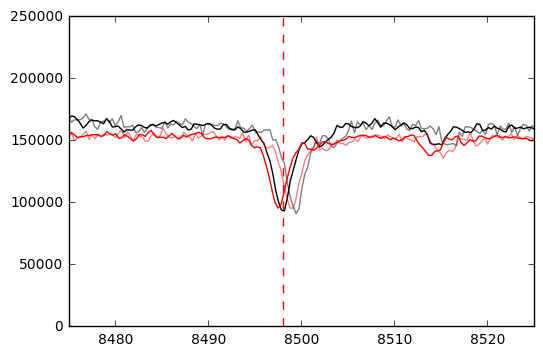

In [92]:
plt.plot(aLambdaR,aSpecR,c='k',alpha=0.5)
plt.plot(aLambdaR,utils.doppler_shift(aLambdaR,aSpecR,-50),c='k')

plt.plot(bLambdaR,bSpecR,c='r',alpha=0.5)
plt.plot(bLambdaR,utils.doppler_shift(bLambdaR,bSpecR,-50),c='r')

plt.axvline(x=8498,c='r',ls='--')
plt.axvline(x=8542,c='r',ls='--')
plt.axvline(x=8662,c='r',ls='--')

#plt.xlim(8475,8675)
plt.xlim(8475,8525)
#plt.xlim(8525,8550)
#plt.xlim(8650,8700)
plt.show()

In [107]:
path = '/Users/Nathan/Downloads/apogee_wavelength.npz'
tmp = np.load(path)
wavelength = tmp['wavelength']
tmp.close()

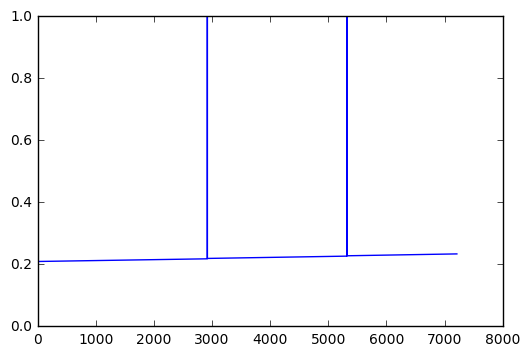

In [113]:
plt.plot(np.diff(wavelength))
plt.ylim(0,1)
plt.show()

In [98]:
np.diff(aLambdaR)

array([ 0.32373047,  0.32373047,  0.32373047, ...,  0.30371094,
        0.30371094,  0.30371094], dtype=float32)

## Predicting spectra w/ NN Results

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

from astropy.io import fits

D_PayneDir = '/Users/Nathan/Documents/Berkeley/Chemical_Evolution/DEIMOS/D-Payne/'

In [15]:
def load_wavelength_array():
    '''
    read in the default wavelength grid onto which we interpolate all spectra
    '''
    path = D_PayneDir + 'other_data/deimos_wavelength.npz'
    tmp = np.load(path)
    wavelength = tmp['wavelength']
    tmp.close()
    return wavelength

def read_in_neural_network(name = 'norm_spectra_approx'):
    '''
    read in the weights and biases parameterizing a particular neural network. 
    You can read in existing networks from the neural_nets/ directory, or you
    can train your own networks and edit this function to read them in. 
    '''
    if name == 'norm_spectra_approx':
        path = D_PayneDir+'neural_nets/NN_norm_spectra_approx.npz'
    elif name == 'norm_spectra_true':
        path = D_PayneDir+'neural_nets/NN_norm_spectra_true.npz'
    else:
        path = name
    tmp = np.load(path)
    
    # some of the networks we train have one hidden layer; others have two. 
    # assume the one we're looking for has two; if it doesn't, we won't find 
    # w_array_2 and b_array_2. 
    try:
        w_array_0 = tmp["w_array_0"]
        w_array_1 = tmp["w_array_1"]
        w_array_2 = tmp["w_array_2"]
        b_array_0 = tmp["b_array_0"]
        b_array_1 = tmp["b_array_1"]
        b_array_2 = tmp["b_array_2"]
        x_min = tmp["x_min"]
        x_max = tmp["x_max"]
        NN_coeffs = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)
    except KeyError:
        w_array_0 = tmp["w_array_0"]
        w_array_1 = tmp["w_array_1"]
        b_array_0 = tmp["b_array_0"]
        b_array_1 = tmp["b_array_1"]
        x_min = tmp["x_min"]
        x_max = tmp["x_max"]
        NN_coeffs = (w_array_0, w_array_1, b_array_0, b_array_1, x_min, x_max)
    tmp.close()
    return NN_coeffs

In [6]:
def sigmoid(z):
    '''
        This is the activation function used by default in all our neural networks.
        You can experiment with using an ReLU instead, but I got worse results in
        some simple tests.
        '''
    return 1.0/(1.0 + np.exp(-z))

def get_spectrum_from_neural_net(labels, NN_coeffs):
    '''
        Predict the rest-frame spectrum (normalized or unnormalized) of a single star.
        Note that the NN_coeffs (and potentially, labels) can be different depending on
        whether we're getting a normalized or unnormalized spectrum.
        '''
    
    # assuming your NN was only a single hidden layer.
    try:
        w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs
        n_hidden = 2
    except ValueError:
        w_array_0, w_array_1, b_array_0, b_array_1, x_min, x_max = NN_coeffs
        n_hidden = 1
    scaled_labels = (labels - x_min)/(x_max - x_min) - 0.5
    
    if n_hidden == 1:
        # This is just efficient matrix multiplication---quite a bit faster than np.dot()
        inside = np.einsum('ijk,k->ij', w_array_0, scaled_labels) + b_array_0
        outside = np.einsum('ij,ij->i', w_array_1, sigmoid(inside)) + b_array_1
    elif n_hidden == 2:
        # I'm not familiar enough with einsum to do the same for NN with 2 hidden layers
        inside = sigmoid(np.dot(w_array_0,scaled_labels) + b_array_0)
        middle = sigmoid(np.sum(w_array_1 * inside, axis = 1) + b_array_1)
        outside = w_array_2 * middle + b_array_2
    spectrum = outside
    return spectrum

In [7]:
NN_coeffs = read_in_neural_network(name='norm_spectra_approx')
labels = np.array([0,0,0,0,0,0,0,0,5780,4.438])

spec = get_spectrum_from_neural_net(labels,NN_coeffs)
wave = load_wavelength_array()

In [10]:
temp = np.genfromtxt(D_PayneDir+'spectra/sao2010.solref')
wave_sol = temp.T[0] * 10
spec_sol = temp.T[2]

temp = fits.open(D_PayneDir+'spectra/ardata.fits')
wave_arc = temp[1].data['WAVELENGTH']
spec_arc = temp[1].data['ARCTURUS']
spec_sol2 = temp[1].data['SOLARFLUX']

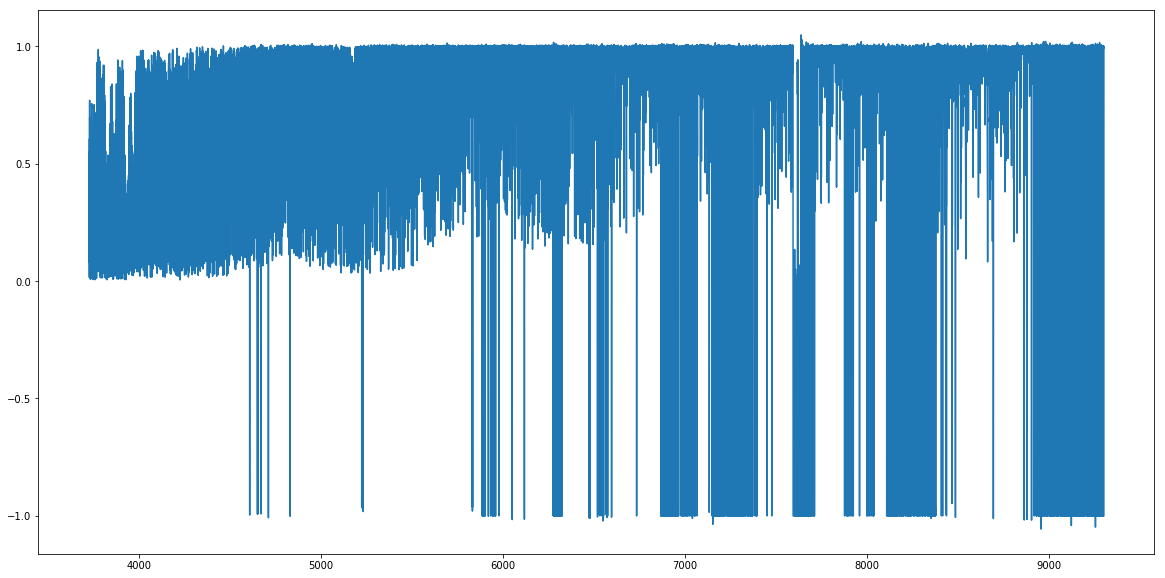

In [32]:
#plt.plot(wave_sol,spec_sol)
plt.plot(wave_arc,spec_arc)
#plt.plot(wave_arc,spec_sol2)
plt.show()

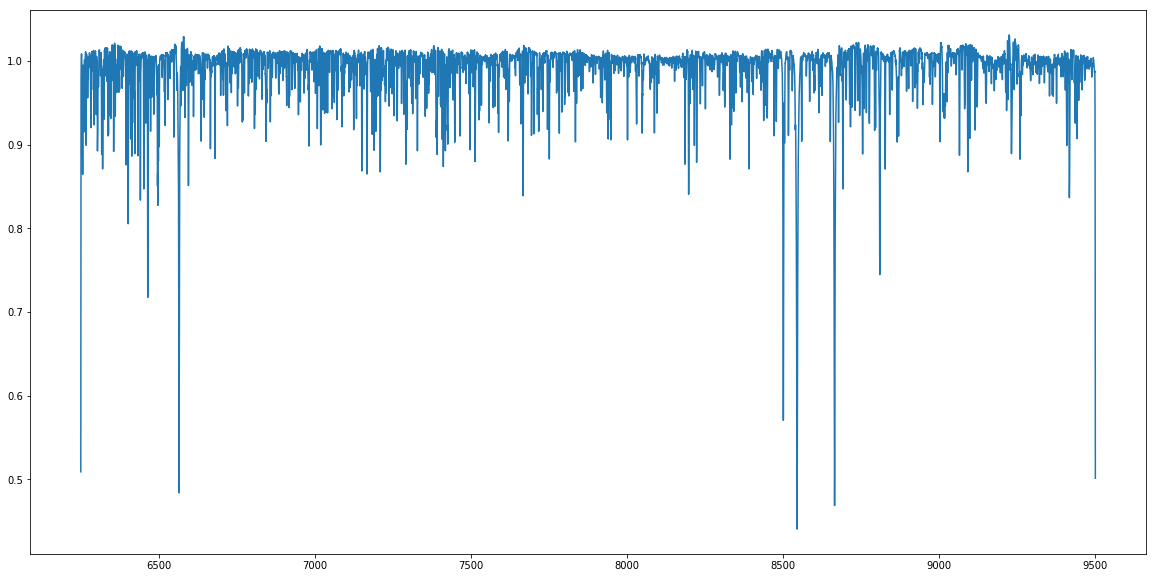

In [186]:
plt.plot(wave,spec)
plt.show()

In [160]:
b_array_2

array([ 1.74429488, -2.24346685,  2.547966  , ...,  0.85663831,
        1.32124853, -1.33629727], dtype=float32)